In [1]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("../Datos/noticias_bitcoin_sentimientos.csv")#../Datos/noticias_bitcoin_sentimientos.csv
df_btc=pd.read_csv("../Datos/BTC_USD_Media_Movil.csv")#../Datos/BTC_USD_Media_Movil.csv
df_btc['Date']=pd.to_datetime(df_btc['Date'], format='%Y-%m-%d')
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1096 non-null   datetime64[ns]
 1   Close      1096 non-null   float64       
 2   High       1096 non-null   float64       
 3   Low        1096 non-null   float64       
 4   Open       1096 non-null   float64       
 5   Volume     1096 non-null   float64       
 6   Close_7d   1090 non-null   float64       
 7   Volume_7d  1090 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.7 KB


In [4]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [5]:
df_model=df_btc[['Date','Close']]
df_model = pd.merge(df_model, df_news_avg_score, how='left', left_on='Date', right_on='fecha')
df_model.fillna(0, inplace=True)
df_model.drop(columns=['fecha'], inplace=True)
df_model['Date'] = pd.to_datetime(df_model['Date'])

C:\Users\SANTI\AppData\Local\Temp\ipykernel_5200\1242759099.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_model.fillna(0, inplace=True)


In [6]:
df_model = df_model.iloc[1:]

## Implementacion del modelo

In [34]:
!pip install prophet


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Felipe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 1 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1096 non-null   datetime64[ns]
 1   Close   1096 non-null   float64       
 2   score   1096 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB


In [36]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [37]:
# Renombrar columnas a las que espera Prophet
df = df_model.rename(columns={
    'Date': 'ds',
    'Close': 'y'
})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

# Verificar que no haya valores nulos
print(df.isnull().sum())

ds       0
y        0
score    0
dtype: int64


In [38]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Felipe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [39]:
import yfinance as yf


#Importar datos de los ultimos 6 dias
df_btc_h = yf.download('BTC-USD', start='2025-04-05', end='2025-04-11')
df_btc_h.reset_index(inplace=True)
df_btc_h['Date'] = pd.to_datetime(df_btc_h['Date'], format='%Y-%m-%d')
df_btc_h['Close'] = df_btc_h['Close'].round(2)
df_btc_h.head(10)

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2025-04-05,83504.80,84207.015625,82377.734375,83844.703125,14380803631
1,2025-04-06,78214.48,83704.718750,77097.742188,83504.507812,36294853736
2,2025-04-07,79235.34,81119.062500,74436.679688,78221.335938,91262424987
3,2025-04-08,76271.95,80823.890625,76198.023438,79218.476562,48314590749
4,2025-04-09,82573.95,83541.000000,74589.671875,76273.562500,84213627038
5,2025-04-10,79626.14,82700.929688,78456.132812,82565.976562,44718000633


In [40]:
df_btc_h.columns = ['_'.join([c for c in col if c]).strip() if isinstance(col, tuple) else col for col in df_btc_h.columns]

# Luego renombrar normalmente
df_btc_h = df_btc_h.rename(columns=({"fecha_":"fecha", "Close_BTC-USD":"Close"}))

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import mlflow
import mlflow.pyfunc
from sklearn.metrics import mean_absolute_error, mean_squared_error
import subprocess
import os
import time
import socket
import cloudpickle
import yfinance as yf

# Función para encontrar un puerto disponible
def find_available_port(start_port=5000, max_port=5050):
    for port in range(start_port, max_port):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            if s.connect_ex(('localhost', port)) != 0:
                return port
    return start_port

# Función para iniciar el servidor MLflow en un hilo separado
def start_mlflow_server(port):
    mlflow_process = subprocess.Popen(
        f"mlflow ui --port {port}",
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    return mlflow_process

# Clase para encapsular el modelo Prophet y permitir registrarlo en MLflow
class ProphetWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
        
    def predict(self, context, model_input):
        # Para Prophet, necesitamos un DataFrame con columnas 'ds' y cualquier regresor adicional
        future = self.model.make_future_dataframe(periods=30)
        # Agregar regresores si existen en model_input
        if 'score' in model_input.columns:
            future['score'] = model_input['score']
        
        # Realizar la predicción
        forecast = self.model.predict(future)
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Configura el experimento MLflow
mlflow.set_experiment("Bitcoin_Price_Prediction_Prophet")

# Ejecutar el modelo Prophet
with mlflow.start_run(run_name="prophet_price_model") as prophet_run:
    print("Entrenando y registrando modelo Prophet...")
    
    # Preparar datos para Prophet
    df_prophet = df_model.rename(columns={
        'Date': 'ds',
        'Close': 'y'
    })
    
    # Asegurar que 'ds' sea datetime
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    
    # Verificar que no haya valores nulos
    print("Valores nulos en dataframe:")
    print(df_prophet.isnull().sum())
    
 
    
    # Parámetros del modelo Prophet
    prophet_params = {
        "growth": "linear",
        "changepoint_prior_scale": 0.09,
        "changepoint_range": 0.8,
        "yearly_seasonality": "auto",
        "weekly_seasonality": "auto",
        "daily_seasonality": "auto",
        "seasonality_mode": "additive",
        "seasonality_prior_scale": 10.0,
        "holidays_prior_scale": 10.0,
        "interval_width": 0.80,
        "uncertainty_samples": 1000
    }
    
    # Registrar parámetros en MLflow
    for param_name, param_value in prophet_params.items():
        mlflow.log_param(param_name, param_value)
    
    # Crear el modelo Prophet
    modelo = Prophet(
        growth=prophet_params["growth"],
        changepoint_prior_scale=prophet_params["changepoint_prior_scale"],
        changepoint_range=prophet_params["changepoint_range"],
        yearly_seasonality=prophet_params["yearly_seasonality"],
        weekly_seasonality=prophet_params["weekly_seasonality"],
        daily_seasonality=prophet_params["daily_seasonality"],
        seasonality_mode=prophet_params["seasonality_mode"],
        seasonality_prior_scale=prophet_params["seasonality_prior_scale"],
        holidays_prior_scale=prophet_params["holidays_prior_scale"],
        interval_width=prophet_params["interval_width"],
        uncertainty_samples=prophet_params["uncertainty_samples"]
    )
    
    # Añadir 'score' como regresor
    modelo.add_regressor('score')
    mlflow.log_param("regressor", "score")
    
    # Entrenar modelo
    modelo.fit(df_prophet)
    
    # Crear fechas futuras para predecir 30 días
    futuro = modelo.make_future_dataframe(periods=30)
    
    # Agregar score futuro (usamos último valor como aproximación)
    ultimo_score = df_prophet['score'].iloc[-1]
    futuro['score'] = list(df_prophet['score']) + [ultimo_score]*30
    
    # Predecir
    pronostico = modelo.predict(futuro)
    
    # Evaluar Prophet en los últimos días (comparando con datos reales)
    try:
        # Asegurarse de que ambos dataframes tengan fechas en el mismo formato
        pronostico_reciente = pronostico.copy()
        pronostico_reciente['ds'] = pd.to_datetime(pronostico_reciente['ds'])
        
        df_btc_h_temp = df_btc_h.copy()
        df_btc_h_temp['Date'] = pd.to_datetime(df_btc_h_temp['Date'])
        
        # Convertir fechas a cadenas en formato YYYY-MM-DD para facilitar la comparación
        pronostico_reciente['fecha'] = pronostico_reciente['ds'].dt.strftime('%Y-%m-%d')
        df_btc_h_temp['fecha'] = df_btc_h_temp['Date'].dt.strftime('%Y-%m-%d')
        
        # Filtrar solo las predicciones para fechas que están en los datos reales
        fechas_reales = set(df_btc_h_temp['fecha'])
        pronostico_filtrado = pronostico_reciente[pronostico_reciente['fecha'].isin(fechas_reales)]
        
        # Crear dataframes para la comparación
        df_pred = pronostico_filtrado[['fecha', 'yhat']]
        df_real = df_btc_h_temp[['fecha', 'Close']]
        print(df_real)
        # Unir por fecha
        comparacion = pd.merge(df_pred, df_real, on='fecha', how='inner')
        print(comparacion.head())
        # Verificar que hay datos para comparar
        if len(comparacion) == 0:
            print("No hay fechas coincidentes entre predicciones y datos reales.")
            prophet_mae = None
            prophet_rmse = None
        else:
            # Mostrar los datos para verificación
            print("Datos para evaluación:")
            print(comparacion)
            
            # Calcular métricas
            prophet_mae = mean_absolute_error(comparacion['Close'], comparacion['yhat'])
            prophet_rmse = np.sqrt(mean_squared_error(comparacion['Close'], comparacion['yhat']))
            
            print(f"Prophet - MAE: {prophet_mae:.2f}")
            print(f"Prophet - RMSE: {prophet_rmse:.2f}")
    except Exception as e:
        print(f"Error al calcular métricas: {e}")
        import traceback
        traceback.print_exc()
        prophet_mae = None
        prophet_rmse = None
    
    # Registrar métricas solo si pudieron calcularse
    if prophet_mae is not None and prophet_rmse is not None:
        mlflow.log_metric("mae", prophet_mae)
        mlflow.log_metric("rmse", prophet_rmse)
    else:
        mlflow.log_metric("mae", 0)
        mlflow.log_metric("rmse", 0)
        print("No se pudieron calcular las métricas correctamente. Se registraron como 0.")
    
   
   
    
    # Registrar el modelo Prophet en MLflow
    prophet_wrapper = ProphetWrapper(modelo)
    
    # Guardar modelo con pickle
    with open("../Datos/prophet_model.pkl", "wb") as f:
        cloudpickle.dump(modelo, f)
    
    # Registrar modelo en MLflow
    mlflow.pyfunc.log_model(
        artifact_path="prophet_model",
        python_model=prophet_wrapper,
        artifacts={"prophet_model": "../Datos/prophet_model.pkl"},
        registered_model_name="Prophet_Bitcoin_Price_Prediction"
    )
    
    prophet_run_id = prophet_run.info.run_id
    print(f"Modelo Prophet guardado en MLflow (Run ID: {prophet_run_id})")

# Iniciar el servidor MLflow
mlflow_port = find_available_port()
mlflow_process = start_mlflow_server(mlflow_port)

print(f"\n===================================================")
print(f"Modelo Prophet registrado en MLflow:")
print(f"Run ID: {prophet_run_id}")
print(f"\nServidor MLflow iniciado en: http://localhost:{mlflow_port}")
print(f"En este servidor puedes ver el experimento y modelo registrado")
print(f"Modelo registrado: 'Prophet_Bitcoin_Price_Prediction'")
print(f"Para detener el servidor, presiona Ctrl+C en la terminal")
print(f"===================================================\n")

# Mantener el script ejecutándose para que el servidor MLflow permanezca activo
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Deteniendo el servidor MLflow...")
    mlflow_process.terminate()
    print("Servidor MLflow detenido.")

C:\Users\Felipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/04/12 22:25:11 INFO mlflow.tracking.fluent: Experiment with name 'Bitcoin_Price_Prediction_Prophet' does not exist. Creating a new experiment.


Entrenando y registrando modelo Prophet...
Valores nulos en dataframe:
ds       0
y        0
score    0
dtype: int64


22:25:11 - cmdstanpy - INFO - Chain [1] start processing
22:25:12 - cmdstanpy - INFO - Chain [1] done processing


        fecha     Close
0  2025-04-05  83504.80
1  2025-04-06  78214.48
2  2025-04-07  79235.34
3  2025-04-08  76271.95
4  2025-04-09  82573.95
5  2025-04-10  79626.14
        fecha          yhat     Close
0  2025-04-05  84488.651054  83504.80
1  2025-04-06  84187.070669  78214.48
2  2025-04-07  83928.406100  79235.34
3  2025-04-08  83473.645100  76271.95
4  2025-04-09  83268.098271  82573.95
Datos para evaluación:
        fecha          yhat     Close
0  2025-04-05  84488.651054  83504.80
1  2025-04-06  84187.070669  78214.48
2  2025-04-07  83928.406100  79235.34
3  2025-04-08  83473.645100  76271.95
4  2025-04-09  83268.098271  82573.95
5  2025-04-10  82827.169470  79626.14
Prophet - MAE: 3791.06
Prophet - RMSE: 4495.51


2025/04/12 22:25:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Prophet_Bitcoin_Price_Prediction' already exists. Creating a new version of this model...
Created version '18' of model 'Prophet_Bitcoin_Price_Prediction'.


Modelo Prophet guardado en MLflow (Run ID: a017e15f3fd4448c88eb07fc46cedea6)

Modelo Prophet registrado en MLflow:
Run ID: a017e15f3fd4448c88eb07fc46cedea6

Servidor MLflow iniciado en: http://localhost:5015
En este servidor puedes ver el experimento y modelo registrado
Modelo registrado: 'Prophet_Bitcoin_Price_Prediction'
Para detener el servidor, presiona Ctrl+C en la terminal

Deteniendo el servidor MLflow...
Servidor MLflow detenido.


Vista del modelo

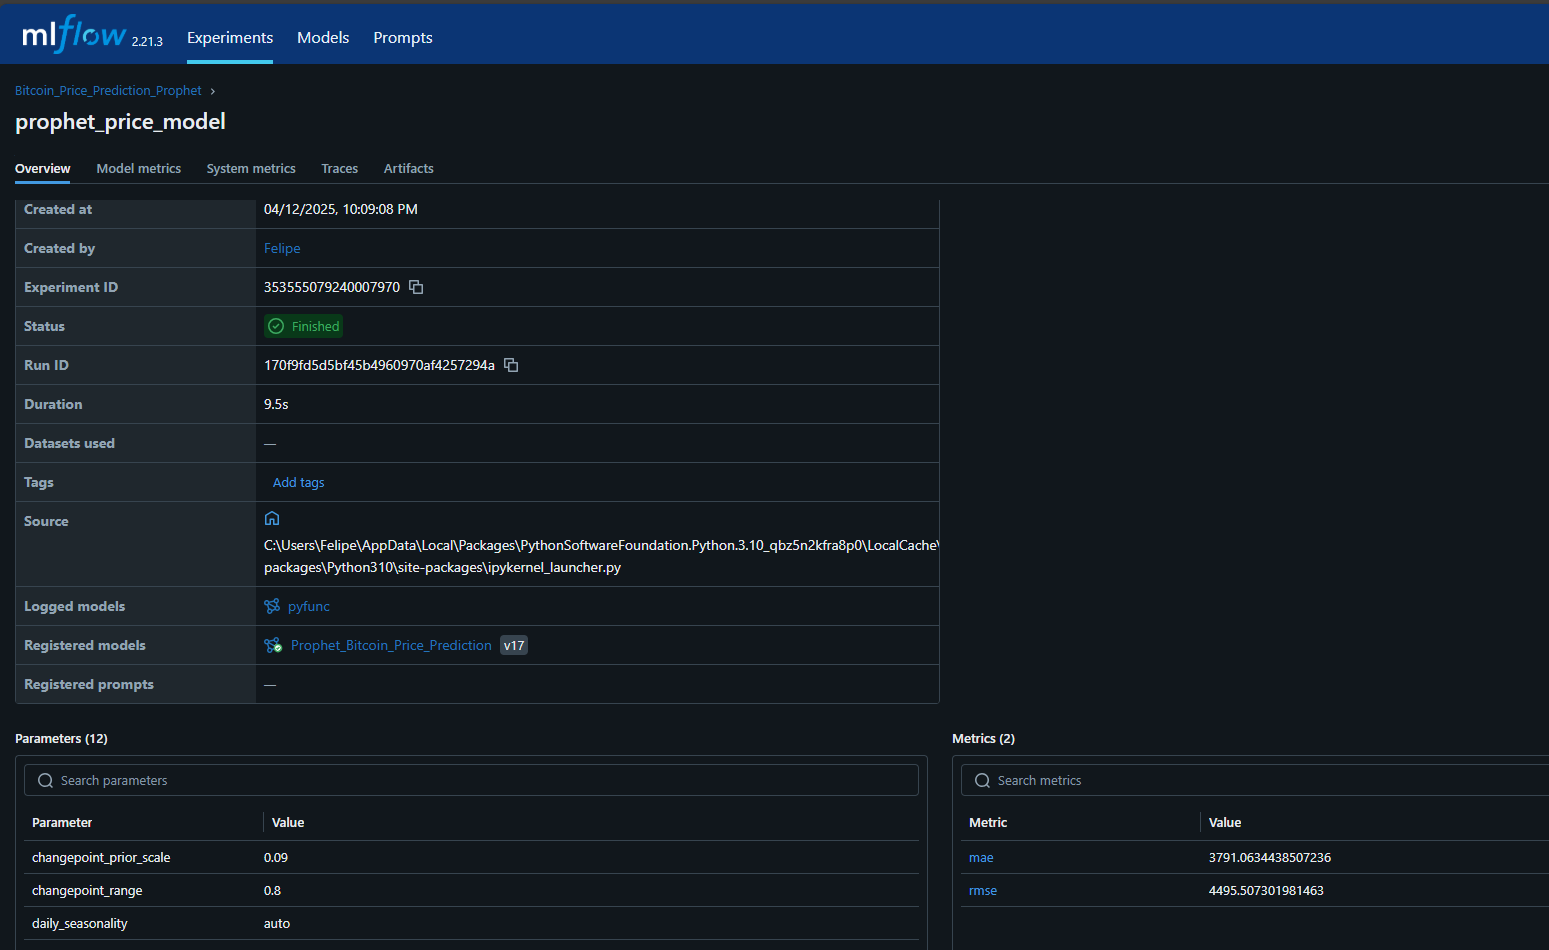

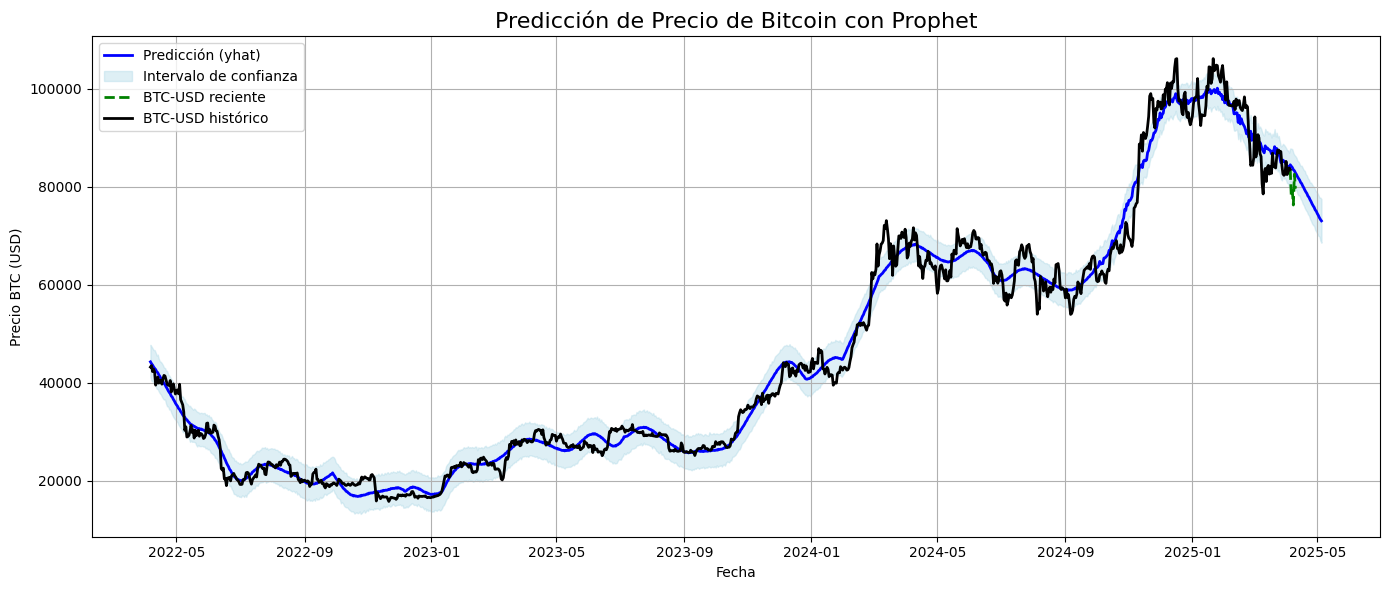

In [ ]:
# Crear figura para visualizar la predicción
plt.figure(figsize=(14, 6))
    
    # Pronóstico completo (línea azul)
plt.plot(pronostico['ds'], pronostico['yhat'], label='Predicción (yhat)', color='blue', linewidth=2)
    
    # Banda de confianza (zona sombreada entre yhat_lower y yhat_upper)
plt.fill_between(pronostico['ds'], pronostico['yhat_lower'], pronostico['yhat_upper'],
                    color='lightblue', alpha=0.4, label='Intervalo de confianza')
    
    # Precio real de BTC (últimos días)
plt.plot(df_btc_h['Date'], df_btc_h['Close'], label='BTC-USD reciente', color='green', linewidth=2, linestyle='--')
    
    # Línea real de BTC (histórico) en negro
plt.plot(df_btc['Date'], df_btc['Close'], label='BTC-USD histórico', color='black', linewidth=2)
    
    # Títulos y etiquetas
plt.title('Predicción de Precio de Bitcoin con Prophet', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio BTC (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()


In [ ]:
# Valor promedio últimos 7 días reales
valor_inicial = df_btc['Close'].tail(7).mean()

# Valor promedio próximos 7 días pronosticados
valor_final = pronostico['yhat'].tail(7).mean()

# Porcentaje de variación
variacion = ((valor_final - valor_inicial) / valor_inicial) * 100

# Mostrar con 2 decimales
print(f"Variación pronosticada 7 días: {variacion:.2f}%")


Variación pronosticada 7 días: -10.97%


In [ ]:
# Valor promedio últimos 14 días reales
valor_inicial = df_btc['Close'].tail(14).mean()

# Valor promedio próximos 14 días pronosticados
valor_final = pronostico['yhat'].tail(14).mean()

# Porcentaje de variación
variacion = ((valor_final - valor_inicial) / valor_inicial) * 100

# Mostrar resultado
print(f"Variación pronosticada 14 días: {variacion:.2f}%")


Variación pronosticada 14 días: -10.74%


In [ ]:
# Valor promedio ultimo mes
valor_inicial= df_btc['Close'].tail(30).mean()
#Valor promedio proximos 30 dias
valor_final = pronostico['yhat'].tail(30).mean()
#Comparar y sacar el porcentaje
variacion = ((valor_final - valor_inicial) / valor_inicial) * 100

print(f"Variación pronosticada 30 días: {variacion:.2f}%")

Variación pronosticada 30 días: -6.34%
